In [1]:
import os
import sys
import yaml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

dname = os.path.abspath('')
module_dir = os.path.abspath("{}/../deeplio".format(dname))
content_dir = os.path.abspath("{}/..".format(dname))
sys.path.append(dname)
sys.path.append(module_dir)
sys.path.append(content_dir)

# change dir to project's root
%cd $content_dir 

/home/ajava/Projects/DeepLIO


In [2]:
from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate
from deeplio.models.misc import DataCombiCreater, build_config_container

# Read configurations
CONFIG_PATH = "{}/config.yaml".format(content_dir)
with open(CONFIG_PATH) as f:
    cfg = yaml.safe_load(f)
    
class Object(object):
    pass
args = Object()
args.batch_size = 1
args.device = 'cpu'

# extracting infos from config file
ds_cfg = cfg['datasets']
kitti_config = ds_cfg['kitti']
seq_size = ds_cfg['sequence-size']
combinations = ds_cfg['combinations']
root_path_sync = kitti_config['root-path-sync']
root_path_unsync = kitti_config['root-path-unsync']

# create directoy to save images
OUTPUT_PATH = "{}/outputs/images".format(content_dir)
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Dataset-Visualization", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataset
batch_size = 1
kitti_dataset = Kitti(config=cfg, transform=None, ds_type='train')
build_config_container(cfg, args)
data_permuter = DataCombiCreater(combinations=combinations)
print("Length of dataset is {}".format(len(kitti_dataset)))

# channel settings
CHANNEL_NAMES = ['x', 'y', 'z', 'nx', 'ny', 'nz']
num_channels = len(CHANNEL_NAMES)


Length of dataset is 20805


In [3]:
data_index = 200

print("Reading one image sample (index={}).".format(data_index))

# get an sample image
dataset, indices = kitti_dataset.get_dataset_and_index(data_index)
data = kitti_dataset.__getitem__(data_index)
data = deeplio_collate([data])
data_permuter(data)
imgs = data_permuter.res_imgs
normals = data_permuter.res_normals
imus = data_permuter.res_imu
imgs_org = data_permuter.res_img_org
normals_org = data_permuter.res_normals_org
gts_f2f = data_permuter.res_gt_f2f
gts_f2g = data_permuter.res_gt_f2g
gts_global = data_permuter.res_gt_global

if imgs is not None:
    print("Image shape: {}".format(imgs.shape))

if imus is not None:
    batch_isze = len(imus)
    seq_size = len(imus[0])
    print("Imu Shape: ({},{},{},{})".format(batch_isze, seq_size, imus[0][0].shape[0], imus[0][0].shape[1]))

Reading one image sample (index=200).
Image shape: torch.Size([1, 4, 2, 3, 57, 720])
Imu Shape: (1,4,11,6)


# Visualizing Raw Images

Image shape:  (57, 720, 6)


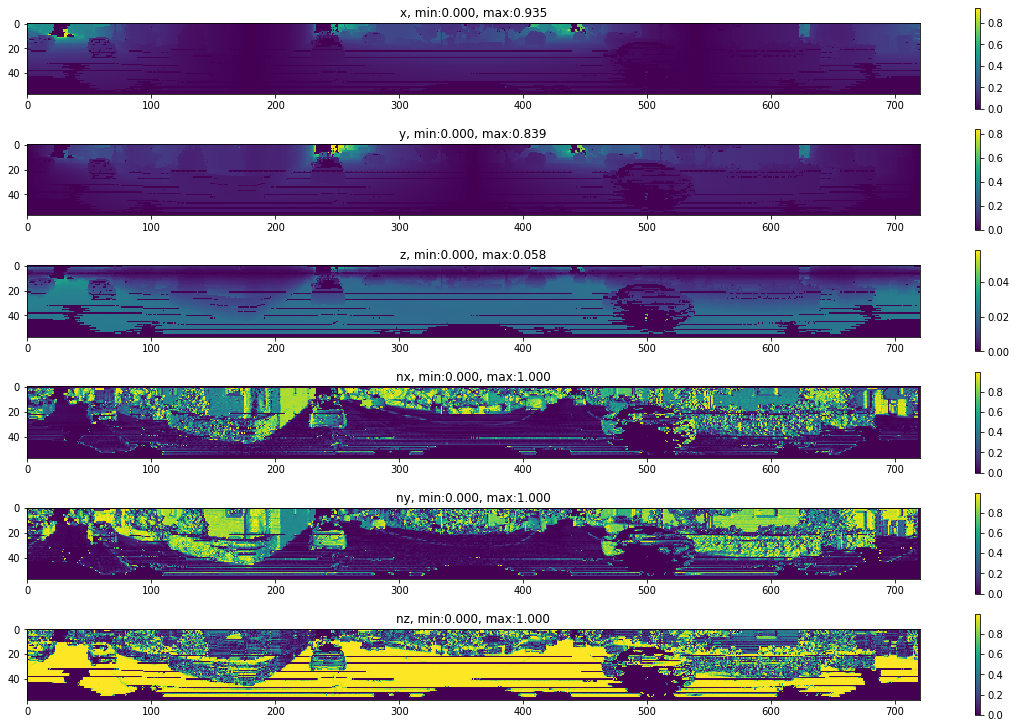

In [4]:
viridis = cm.get_cmap('viridis', 512)
gray = cm.get_cmap('gray', 512)
jet = cm.get_cmap('jet', 512)
CHANNEL_CMAP = [viridis, viridis, viridis, viridis, viridis, viridis]

# convert negativ x, y, z coord. to postive
ims = np.abs(imgs_org[0, 0, 0].numpy().transpose(1, 2, 0))
norms = np.abs(normals_org[0, 0, 0].numpy().transpose(1, 2, 0))
im = np.dstack((ims, norms))

print("Image shape: ", im.shape)

fig, axes = plt.subplots(num_channels, 1, figsize=(20, 13))
for i in range(num_channels):
    ax = axes[i]
    img = im[:, :, i]
    ax.imshow(img, cmap=CHANNEL_CMAP[i])
    ax.set_title("{}, min:{:.3f}, max:{:.3f}".format(CHANNEL_NAMES[i], img.min(), img.max()))
    psm = ax.pcolormesh(img, cmap=CHANNEL_CMAP[i], rasterized=True, vmin=img.min(), vmax=img.max())
    fig.colorbar(psm, ax=ax)
    
fig.savefig("{}/kitti_raw_{}_{}.png".format(OUTPUT_PATH, dataset.date, dataset.drive, indices[0]))

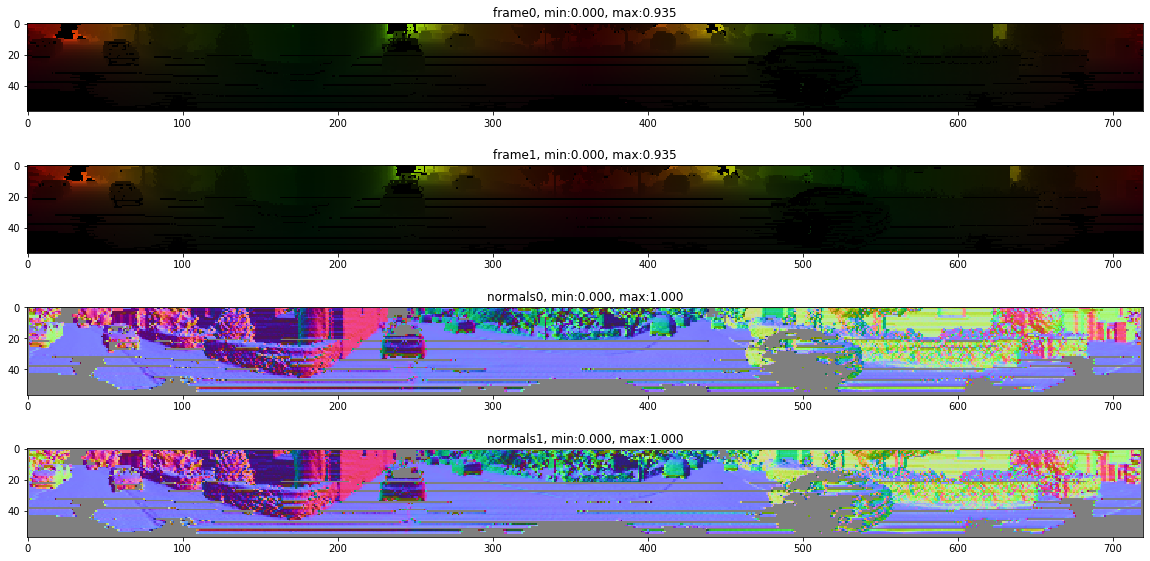

In [5]:
# convert negativ x, y, z coord. to postive
ims_0 = np.abs(imgs_org[0, 0, 0].numpy().transpose(1, 2, 0))
ims_1 = np.abs(imgs_org[0, 0, 1].numpy().transpose(1, 2, 0))

norms_0 = normals_org[0, 0, 0].numpy().transpose(1, 2, 0)
norms_1 = normals_org[0, 0, 1].numpy().transpose(1, 2, 0)

fig, axes = plt.subplots(4, 1, figsize=(20, 10))
axes[0].imshow(ims_0)
axes[0].set_title("{}, min:{:.3f}, max:{:.3f}".format("frame0", ims.min(), ims.max()))

axes[1].imshow(ims_1)
axes[1].set_title("{}, min:{:.3f}, max:{:.3f}".format("frame1", ims.min(), ims.max()))

axes[2].imshow((norms_0 + 1.)/2., cmap=CHANNEL_CMAP[i])
axes[2].set_title("{}, min:{:.3f}, max:{:.3f}".format("normals0", norms.min(), norms.max()))

axes[3].imshow((norms_1 + 1.)/2., cmap=CHANNEL_CMAP[i])
axes[3].set_title("{}, min:{:.3f}, max:{:.3f}".format("normals1", norms.min(), norms.max()))

fig.savefig("{}/kitti_raw_cord_norm_{}_{}.png".format(OUTPUT_PATH, dataset.date, dataset.drive, indices[0]))

# Visualizing Image Gradients

0.7945012995451592


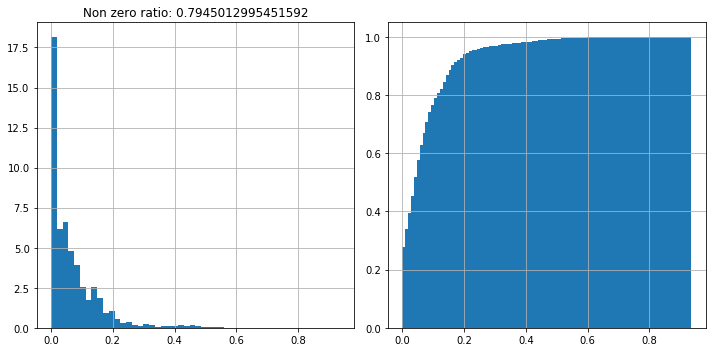

In [6]:
i0 = ims_0.flatten()
ratio = len(i0[i0>0.])/len(i0)
print(ratio)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(ims_0[:, :, 0].flatten(), bins=50, cumulative=0, density=True)
axes[0].set_title("Non zero ratio: {}".format(ratio))
axes[0].grid(True)

axes[1].hist(ims_0[:, :, 0].flatten(), bins=100, cumulative=1, density=True)
axes[1].grid(True)

fig.tight_layout()
fig.savefig("{}/kitti_raw_stat_{}_{}.png".format(OUTPUT_PATH, dataset.date, dataset.drive, indices[0]))
plt.show()

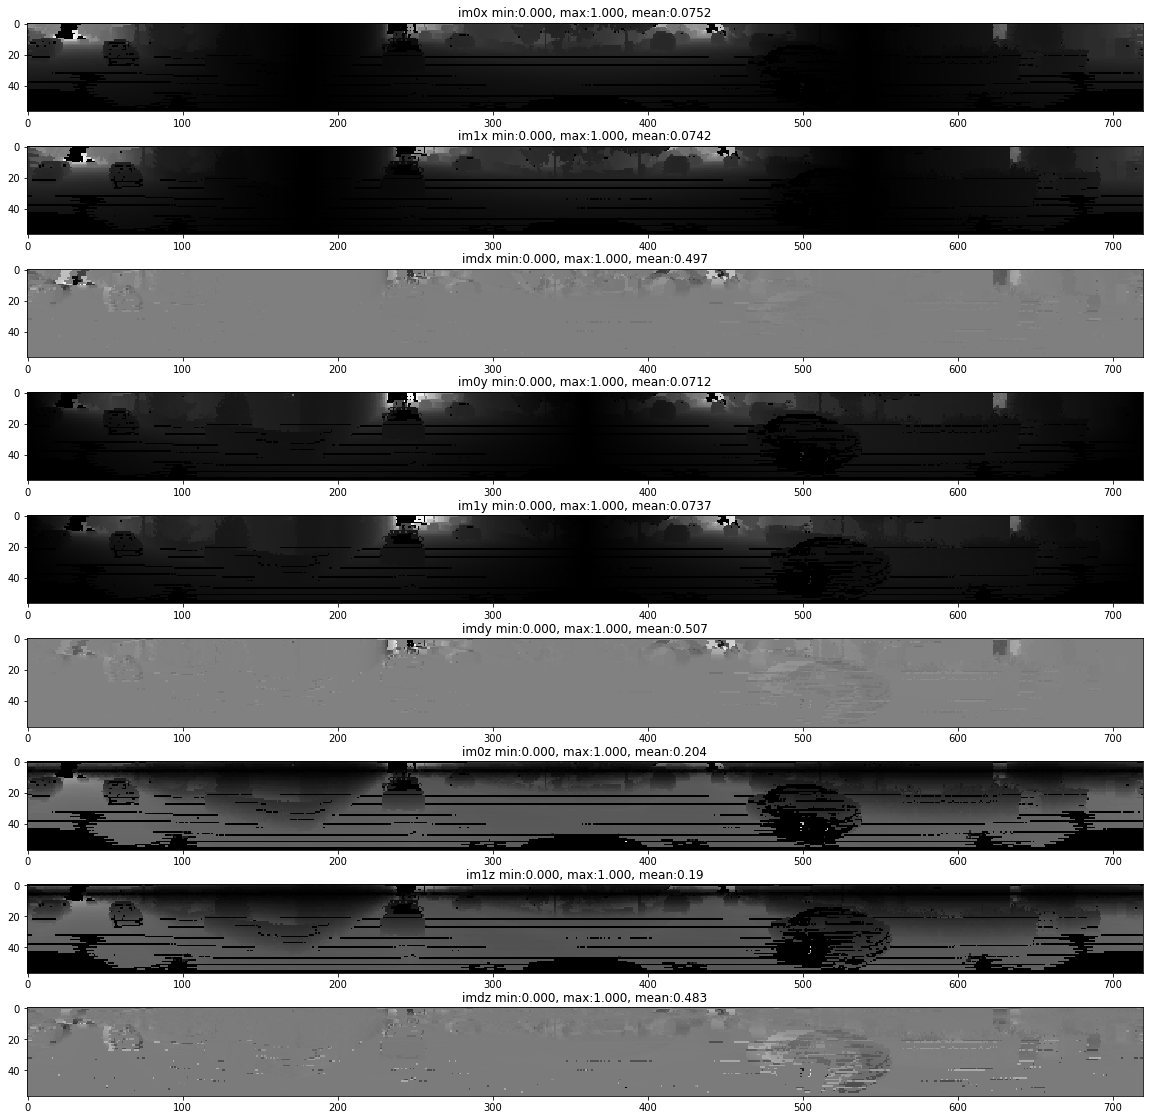

In [7]:
def normalize_image(im):
    return (im - im.min()) / (im.max() - im.min())

im_0 = np.abs(imgs_org[0, 0, 0].numpy().transpose(1, 2, 0))
im_1 = np.abs(imgs_org[0, 0, 1].numpy().transpose(1, 2, 0))

im0x = im_0[:, :, 0]
im0y = im_0[:, :, 1]
im0z = im_0[:, :, 2]

im1x = im_1[:, :, 0]
im1y = im_1[:, :, 1]
im1z = im_1[:, :, 2]

im_dx = im1x - im0x
im_dy = im1y - im0y
im_dz = im1z - im0z

ims_dict = {'im0x': im0x, 'im1x': im1x, 'imdx': im_dx, 'im0y': im0y, 'im1y':im1y, 
        'imdy': im_dy, 'im0z': im0z, 'im1z': im1z, 'imdz': im_dz}

fig, axes = plt.subplots(len(ims_dict), 1, figsize=(20, 20))
for i, (k, img) in enumerate(ims_dict.items()):
    ax = axes[i]
    img = normalize_image(img)
    ax.imshow(img, cmap='gray')
    ax.set_title("{} min:{:.3f}, max:{:.3f}, mean:{:.3}".format(k, img.min(), img.max(), img.mean()))

In [8]:
### 3D plotting

import open3d as o3d

from deeplio.common.utils import *

im = imgs_org[0, 0, 0].numpy().transpose(1, 2, 0)
im_xyz = convert_velo_img_to_pcl(im)
im_xyz_len, _ = im_xyz.shape

norms =  normals_org[0, 0, 0].numpy().transpose(1, 2, 0)
norms_xyz = convert_velo_img_to_pcl(norms)
n_xyz_len, _ = norms_xyz.shape
norms_xyz = np.pad(norms_xyz, ((im_xyz_len - n_xyz_len, 0),(0, 0)))

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(im_xyz)
pcd.normals = o3d.utility.Vector3dVector(norms_xyz)
o3d.visualization.draw_geometries([pcd])

# Average Transformation of the Kitti Dataset 

In [9]:
import logging
import datetime
from pathlib import Path

import torch.utils.data
import torch.nn.functional as F

from deeplio.common.logger import PyLogger, get_app_logger
from deeplio.datasets import Kitti, deeplio_collate


OUTPUT_PATH = "{}/outputs/kittt_avg_trans".format(content_dir)

# create directoy to save images
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Dataset class needs a global logger, so creat it here
# TODO: Remove dependecy of dataset to global logger, so it can have its own
flog_name = "{}/{}_{}.log".format(OUTPUT_PATH, "Kitt-Avg-Trans", datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))
get_app_logger(filename=flog_name, level=logging.INFO)
    
# create dataloader
dataloader = torch.utils.data.DataLoader(kitti_dataset, batch_size=batch_size,
                                       num_workers=0,
                                       shuffle=True,
                                       collate_fn = deeplio_collate)

print("Length of dataset is {}".format(len(dataloader)))

Length of dataset is 9486


In [10]:
from deeplio.common.spatial import rotation_matrix_to_quaternion, quaternion_to_angle_axis

from tqdm import tqdm

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

pbar = tqdm(total=len(dataloader))

x_avg = AverageMeter('x')
q_avg = AverageMeter('q')

# Iterate through datset and save images
for idx, data in enumerate(dataloader):
        
    metas = data['metas'][0]
    index = metas['index'][0]
    date = metas['date'][0]
    drive = metas['drive'][0]

    imgs, imus, gts_local = data_permuter(data)
    
    # prepare ground truth tranlational and rotational part
    gt_pos = gts_local[:, :, 0:3].contiguous()
    gt_rot = gts_local[:, :, 3:7].contiguous()
    
    x_avg.update(gt_pos.mean(dim=0).numpy()) 
    q_avg.update(gt_rot.mean(dim=0).numpy())    
    
    pbar.update(1)
    #if idx % 100 == 0:
    #    print("{} x-avg: {}, q-avg: {}".format(idx, x_avg.avg, q_avg.avg))
print("x-avg: {}, q-avg: {}".format(x_avg.avg, q_avg.avg))


100%|█████████▉| 9485/9486 [07:29<00:00, 21.74it/s]

x-avg: [[9.7009349e-01 1.1915629e-03 7.8270305e-03]
 [1.9400896e+00 2.1429735e-03 1.5536455e-02]
 [9.7011012e-01 1.1921169e-03 7.8262994e-03]], q-avg: [[6.55468966e-06 4.60646588e-05 4.42171004e-05 9.99964356e-01]
 [1.13368715e-05 9.10461240e-05 8.79105282e-05 9.99831557e-01]
 [4.77854519e-06 4.55452646e-05 4.38853676e-05 9.99964714e-01]]


# Visualiziing Ground-Truth Trajectories of KITTI

In [11]:
sequences = ['00', '01', '02', '04', '05', '06', '07', '08', '09', '10', '11', '12']
GTs = [np.dstack(ds.oxts_sync[:, 1]) for  ds in kitti_dataset.datasets]

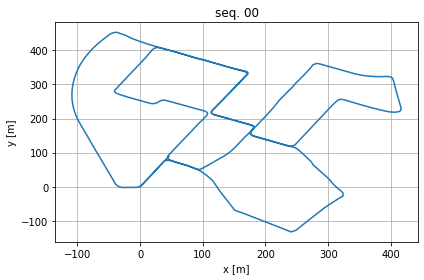

(4, 4, 4544)


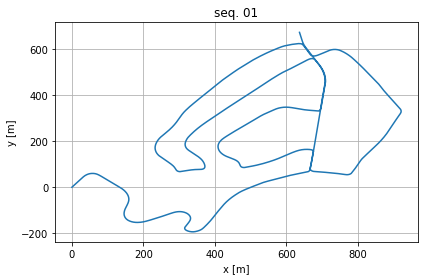

(4, 4, 4663)


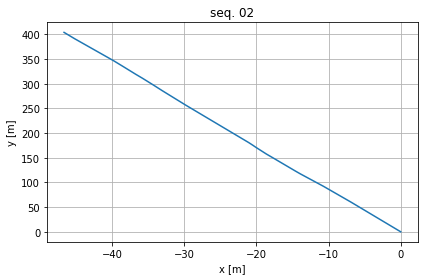

(4, 4, 279)


100%|██████████| 9486/9486 [07:40<00:00, 21.74it/s]

In [12]:
for i, gt in enumerate(GTs):
    fig, ax = plt.subplots(1, 1)
    ax.plot(gt[0, 3, :], gt[1, 3, :])
    ax.grid('true')
    ax.set_title('seq. {}'.format(sequences[i]))
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')    
    fig.tight_layout()
    fig.savefig("{}/kitti_seq_{}.png".format(OUTPUT_PATH, sequences[i]))    
    plt.show()
    print(gt.shape)